# The World Tour of '99: Data Analysis



First we import all the required libraries and functions:
- pandas for pre-processing and handling data
- scikit-learn for machine learning algorithms
- numpy for dealing with numbers
- matplotlib for data visualization

Then we can load our datasheet `tour_logs_train.csv`

In [409]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("tour_logs_train.csv")

We can convert most of the date strings to a pandas `datetime` object using the `coerce` and `mixed` options. 
The remaining labels include stuff like time of day, which can be manually converted to a suitable time.

Then we can extract all the information about the dates into separate numeric columns. The `is_weekend` and `is_night_show` flags can be used as features.

In [410]:
def preprocess_datetime(df):
    df['dt'] = pd.to_datetime(df['Show_DateTime'], errors='coerce', format='mixed')

    df.loc[df["Show_DateTime"] == "Late Night", "dt"] = pd.to_datetime("2024-01-01 23:00:00")
    df.loc[df["Show_DateTime"] == "Evening", "dt"] = pd.to_datetime("2024-01-01 18:00:00")
    df.loc[df["Show_DateTime"] == "Morning", "dt"] = pd.to_datetime("2024-01-01 09:00:00")
    df.loc[df["Show_DateTime"] == "Afternoon", "dt"] = pd.to_datetime("2024-01-01 01:00:00")

    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["hour"] = df["dt"].dt.hour
    df["Day_of_Week"] = df["Day_of_Week"].astype(int)
    df["is_weekend"] = df["Day_of_Week"].isin([5,6]).astype(int)
    df["is_night_show"] = (df["hour"] >= 18).astype(int)

Clip volume level between 1 and 11. In the notes it is mentioned that when volume level is pushed too high, it might display 0 or NA. Hence we convert those to a level of 11.

Clipped volume level can be used as a feature later on.

In [411]:
def preprocess_volume(df):
    df["Volume_Glitched"] = df["Volume_Level"].isna().astype(int)
    df.loc[df["Volume_Level"].le(0) | df["Volume_Level"].isna() | df["Volume_Level"].gt(11), "Volume_Level"] = 11

Convert all the different price formats.
I used AI to get this regex: `r'([$€£]?\s*[\d.,]+)'`
This regex captures a currency symbol followed by any number of digits. This removes the VIP price at the end if present.
The `free_mask` mask checks if the price is "Free", and we can set them to 0 later.

In [412]:
def preprocess_price(df):    
    s = df["Ticket_Price"].astype(str)

    # Used AI to get the following regex
    s = s.str.extract(r'([$€£]?\s*[\d.,]+)', expand=False)
    free_mask = df["Ticket_Price"].str.contains("free", case=False, na=False)
    currency = s.str.extract(r'([$€£])', expand=False)
    value = s.str.extract(r'([\d.,]+)', expand=False)
    value = value.str.replace(",", "", regex=False).astype(float)

    rates = {
        "$": 1.0,
        "€": 1.09,
        "£": 1.27
    }

    df["Ticket_Price"] = value * currency.map(rates).fillna(1.0)
    df.loc[free_mask, "Ticket_Price"] = 0

Clip Opener Rating between 1 and 5, and fill empty ones with the mean value.

In [413]:
def preprocess_opener_rating(df):
    df["Opener_Rating"] = df["Opener_Rating"].clip(1, 5)
    df["Opener_Rating"] = df["Opener_Rating"].fillna(df["Opener_Rating"].mean())

Clip the Crowd energy values between 0 and 100

In [414]:
def preprocess_crowd_energy(df):
    df["Crowd_Energy"] = df["Crowd_Energy"].clip(0, 100)

Fill na values in Crowd_Size

In [415]:
def preprocess_crowd_size(df):
    df["Crowd_Size"] = df["Crowd_Size"].fillna(df["Crowd_Size"].median()).clip(lower=0, upper=1000)

Now we can combine all the preprocess steps into a single function.

In [416]:
def preprocess(df):
    df = df.copy()

    preprocess_datetime(df)
    preprocess_volume(df)
    preprocess_price(df)
    preprocess_opener_rating(df)
    if "Crowd_Energy" in df.columns:
        preprocess_crowd_energy(df)
    if "Crowd_Size" in df.columns:
        preprocess_crowd_size(df)

    return df

df = preprocess(df)

### Testing Volume Limit Hypothesis

We can plot the crowd energy vs volume plot for all the different venues.

Clearly, V_Alpha (the monks) is the venue with a volume limit.

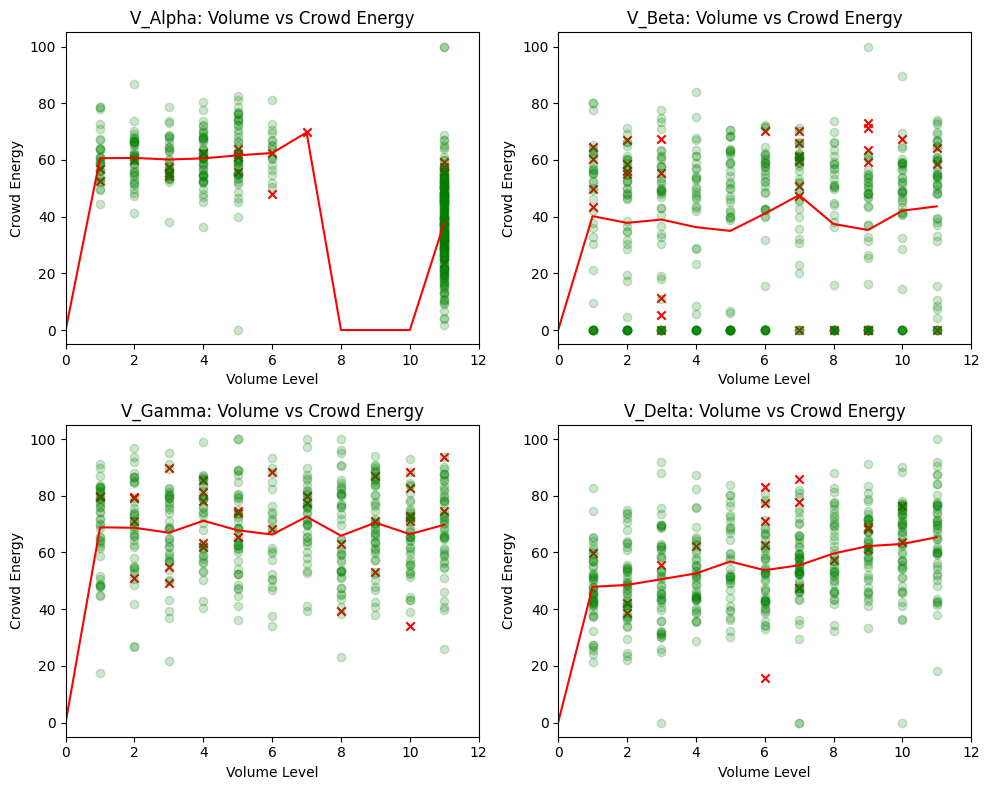

In [417]:
venues = ["V_Alpha", "V_Beta", "V_Gamma", "V_Delta"]

plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    avg_energy_at_vol = sub.groupby("Volume_Level")["Crowd_Energy"].mean().reindex(range(0, 12), fill_value = 0)

    unpacked = sub[sub["Crowd_Size"] <= 800]
    packed = sub[sub["Crowd_Size"] > 800]
    
    plt.subplot(2, 2, i)
    plt.scatter(packed["Volume_Level"], packed["Crowd_Energy"], color="red", marker="x")
    plt.scatter(unpacked["Volume_Level"], unpacked["Crowd_Energy"], color="green", alpha=0.2)
    plt.plot(avg_energy_at_vol.index, avg_energy_at_vol, color="red")
    plt.title(f"{v}: Volume vs Crowd Energy")
    plt.xlabel("Volume Level")
    plt.ylabel("Crowd Energy")
    plt.xlim(0, 12)

plt.tight_layout()
plt.show()


### Testing Tuesday Hypothesis

This is a plot of the crowd energies and the average crowd energy for every day of the week. 

There is no visible peak on tuesday's or any particular day. Hence the hypothesis is false. 
However, there is slight increase in energy on the weekends (Day 5 and 6).

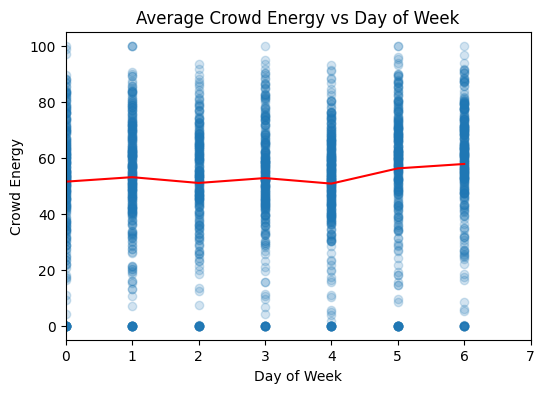

In [418]:
avg_energy_at_day = df.groupby("Day_of_Week")["Crowd_Energy"].mean().reindex(range(0, 7), fill_value = 0)

plt.figure(figsize=(6,4))
plt.scatter(df["Day_of_Week"], df["Crowd_Energy"], alpha=0.2, marker="o")
plt.plot(avg_energy_at_day.index, avg_energy_at_day, color="red")
plt.title("Average Crowd Energy vs Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Crowd Energy")
plt.xlim(0, 7)
plt.show()

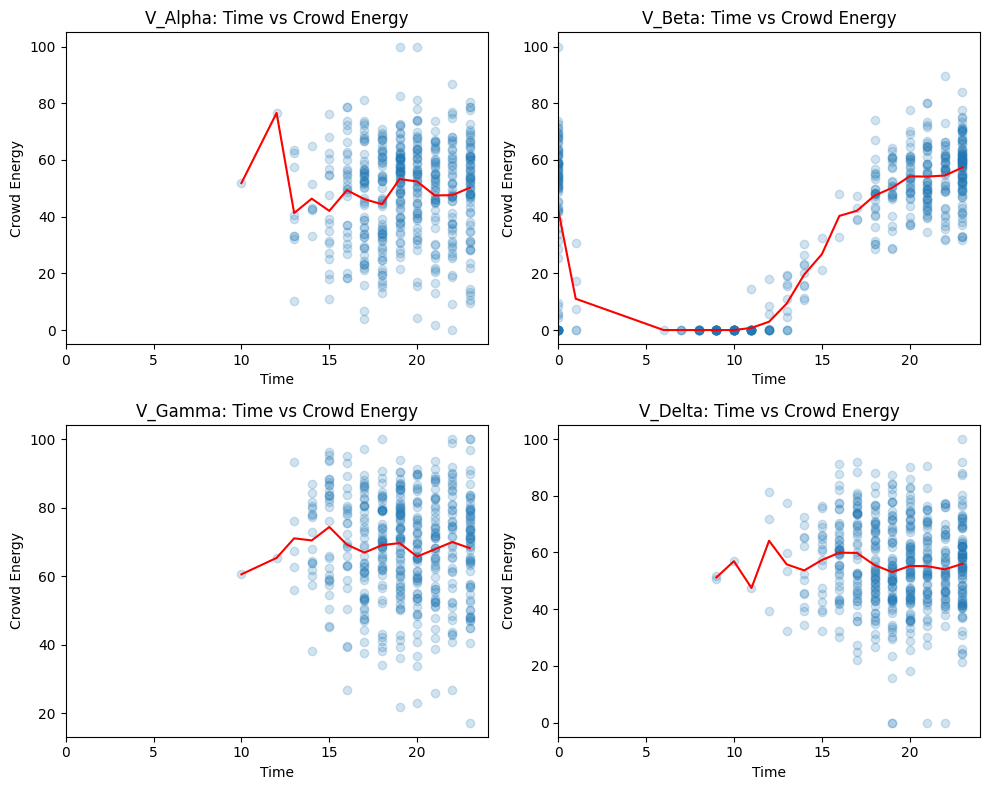

In [419]:
plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    avg_energy_at_hour = sub.groupby("hour")["Crowd_Energy"].mean()
    
    plt.subplot(2, 2, i)
    plt.scatter(sub["hour"], sub["Crowd_Energy"], alpha=0.2, marker="o")
    plt.plot(avg_energy_at_hour.index, avg_energy_at_hour, color="red")
    plt.title(f"{v}: Time vs Crowd Energy")
    plt.xlabel("Time")
    plt.ylabel("Crowd Energy")
    plt.xlim(0, 24)

plt.tight_layout()
plt.show()

### Testing Moon Phase Hypothesis

We can plot the different crowd energy values against the phases of the moon.

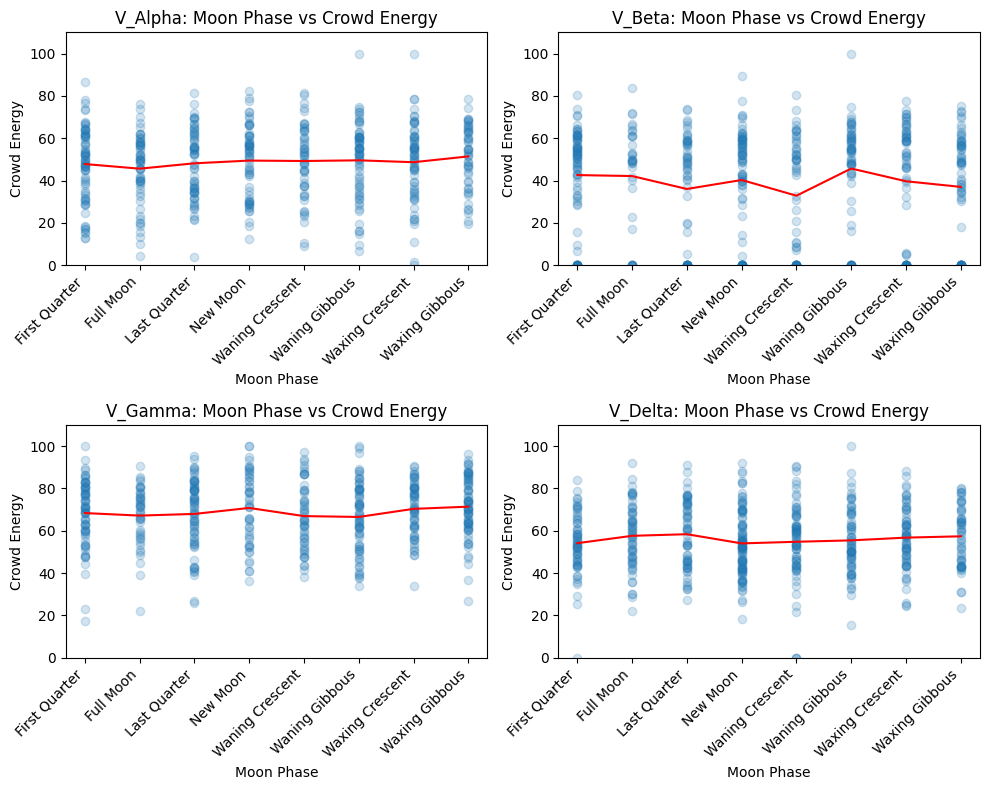

In [420]:
plt.figure(figsize=(10, 8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    avg_energy = (
        sub.groupby("Moon_Phase")["Crowd_Energy"]
           .mean()
           .sort_index()
           
    )
    order = avg_energy.index
    sub = sub.sort_values("Moon_Phase")

    plt.subplot(2, 2, i)
    plt.scatter(sub["Moon_Phase"], sub["Crowd_Energy"], alpha=0.2)
    plt.plot(order, avg_energy, color="red")
    plt.xticks(order, rotation=45, ha="right")

    plt.title(f"{v}: Moon Phase vs Crowd Energy")
    plt.xlabel("Moon Phase")
    plt.ylabel("Crowd Energy")
    plt.ylim(0, 110)
    plt.xticks(rotation=45, ha="right")


plt.tight_layout()
plt.show()


### Price Sensitivity

We can plot the crowd energies against Ticket price and fit a linear regression to it. Clearly, **V_Gamma is the one with the price sensitivity.**

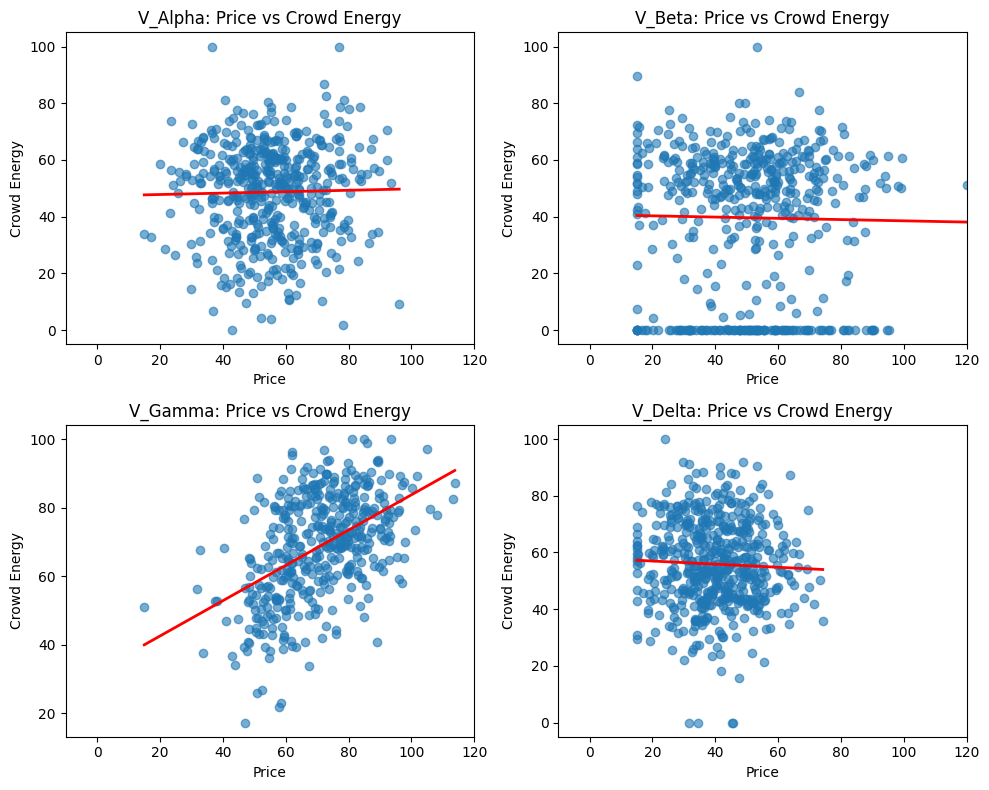

In [421]:
plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    sub = sub[sub["Ticket_Price"] >= 1]

    # avg_energy_at_price = sub.groupby("hour")["Crowd_Energy"].mean()
    X = sub["Ticket_Price"].to_numpy().reshape(-1, 1)
    y = sub["Crowd_Energy"].to_numpy()
    reg = LinearRegression().fit(X, y)

    x_line = np.linspace(sub["Ticket_Price"].min(), sub["Ticket_Price"].max(), 200)
    y_line = reg.predict(x_line.reshape(-1, 1))
    
    plt.subplot(2, 2, i)
    plt.scatter(sub["Ticket_Price"], sub["Crowd_Energy"], alpha=0.6, marker="o")
    plt.plot(x_line, y_line, color="red", linewidth=2)
    plt.title(f"{v}: Price vs Crowd Energy")
    plt.xlabel("Price")
    plt.ylabel("Crowd Energy")
    plt.xlim(-10, 120)

plt.tight_layout()
plt.show()


### Dependence on Opener Rating

Plotting the Crowd Energy vs Opener Rating, we can see that V_Gamma has a slight dependence on the opener rating.

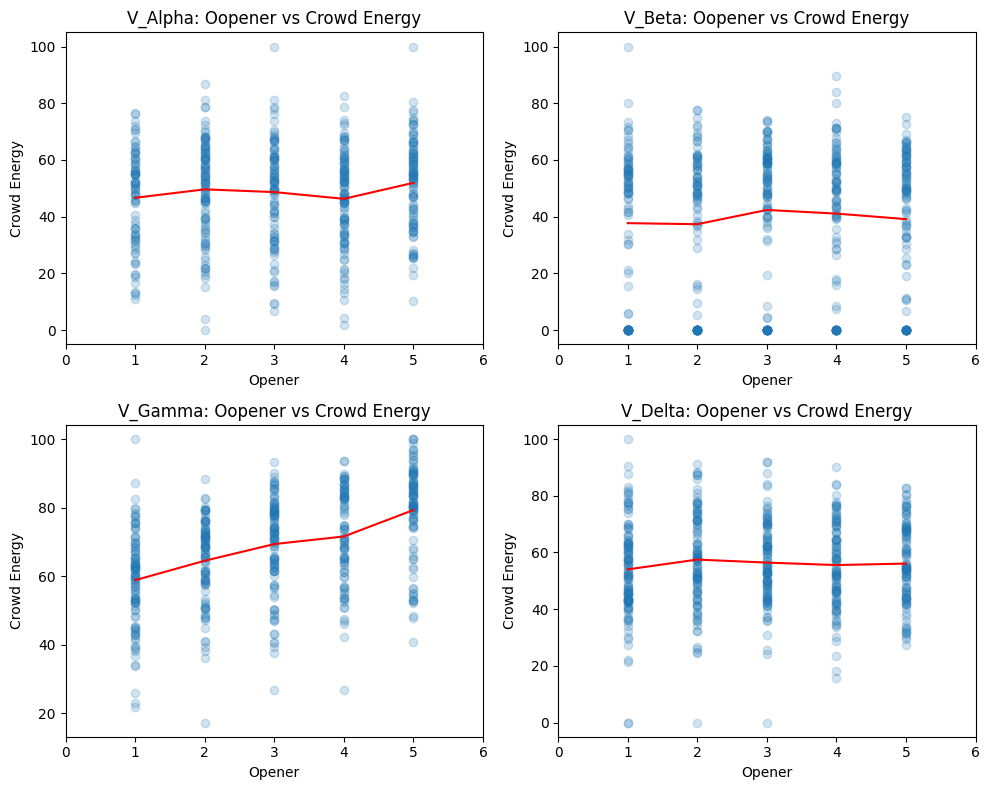

In [422]:
plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    avg_energy_at_opener = sub.groupby("Opener_Rating")["Crowd_Energy"].mean().reindex(range(1, 6), fill_value = 0)

    unpacked = sub[sub["Crowd_Size"] <= 800]
    packed = sub[sub["Crowd_Size"] > 800]
    
    plt.subplot(2, 2, i)
    plt.scatter(sub["Opener_Rating"], sub["Crowd_Energy"], alpha=0.2, marker="o")
    plt.plot(avg_energy_at_opener.index, avg_energy_at_opener, color="red")
    plt.title(f"{v}: Oopener vs Crowd Energy")
    plt.xlabel("Opener")
    plt.ylabel("Crowd Energy")
    plt.xlim(0, 6)

plt.tight_layout()
plt.show()


### Dependence on Outfit

We can plot the crowd energies for the different band outfits at the different venues.

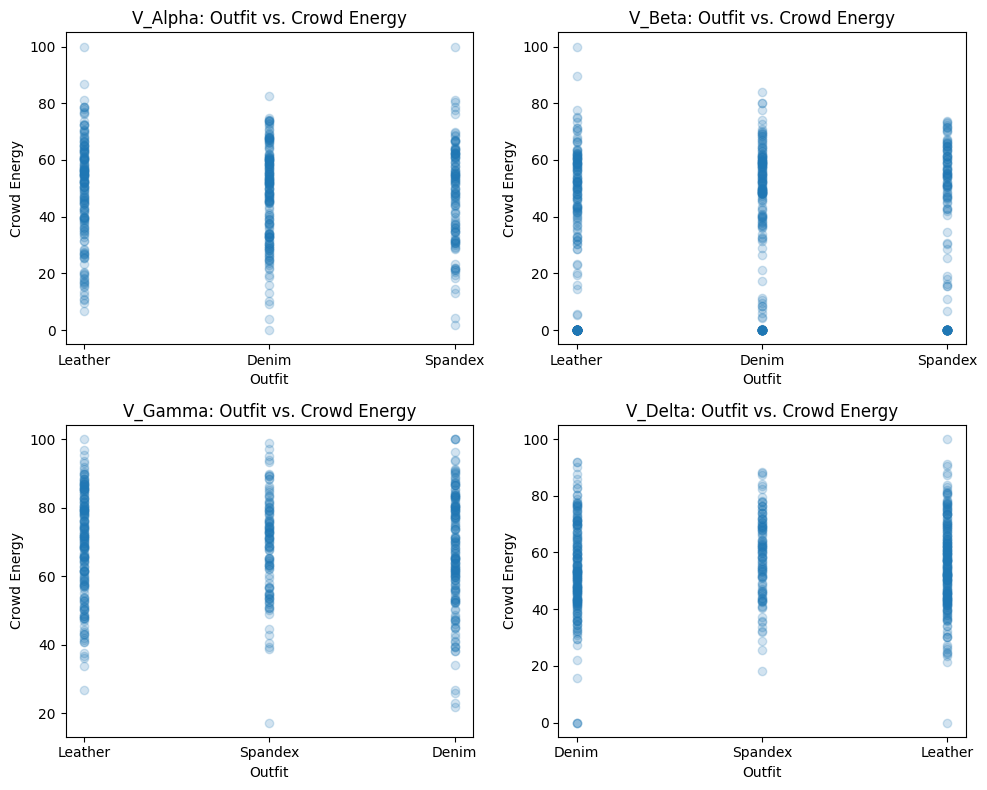

In [423]:
plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    plt.subplot(2, 2, i)
    plt.scatter(sub["Band_Outfit"], sub["Crowd_Energy"], alpha=0.2, marker="o")
    plt.title(f"{v}: Outfit vs. Crowd Energy")
    plt.xlabel("Outfit")
    plt.ylabel("Crowd Energy")
    # plt.xlim(0, 13)

plt.tight_layout()
plt.show()

### Dependence on Weather

No clear relationship between weather and crowd energy.
V_Delta had some great shows on clear days.

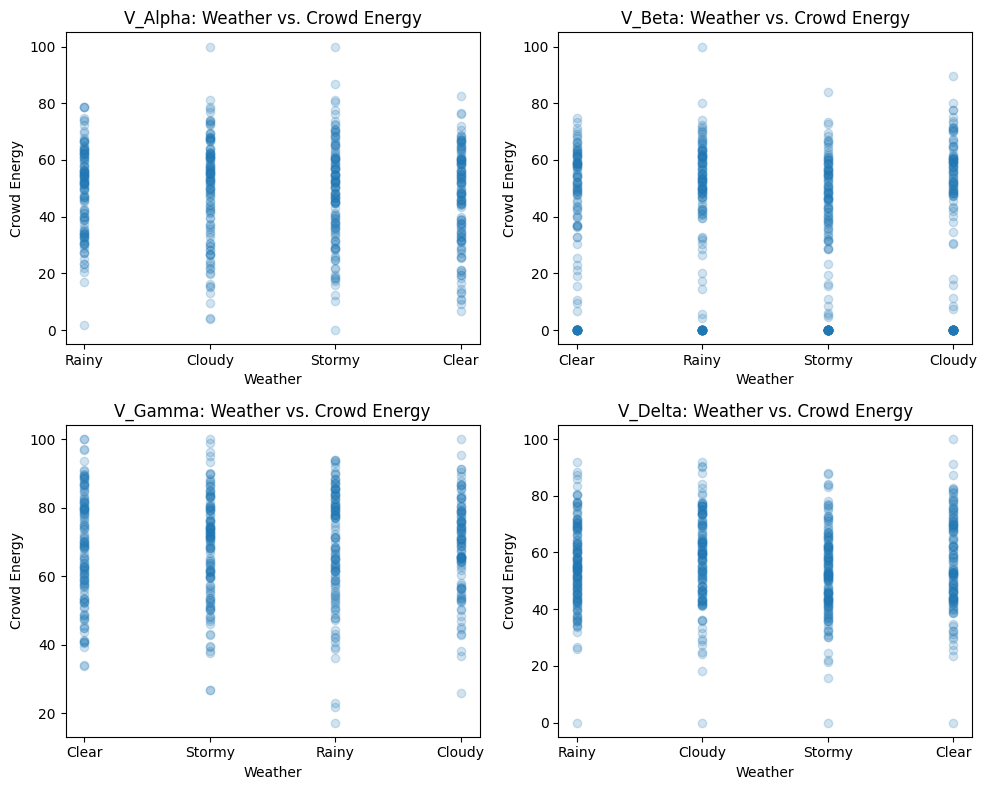

In [424]:
plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    plt.subplot(2, 2, i)
    plt.scatter(sub["Weather"], sub["Crowd_Energy"], alpha=0.2, marker="o")
    plt.title(f"{v}: Weather vs. Crowd Energy")
    plt.xlabel("Weather")
    plt.ylabel("Crowd Energy")

plt.tight_layout()
plt.show()

### Relation etween Crowd Size and Energy

We can plot the crowd size against energy, and see if there's a relationship.

There is only a slight positive correlation, but it's not strong.

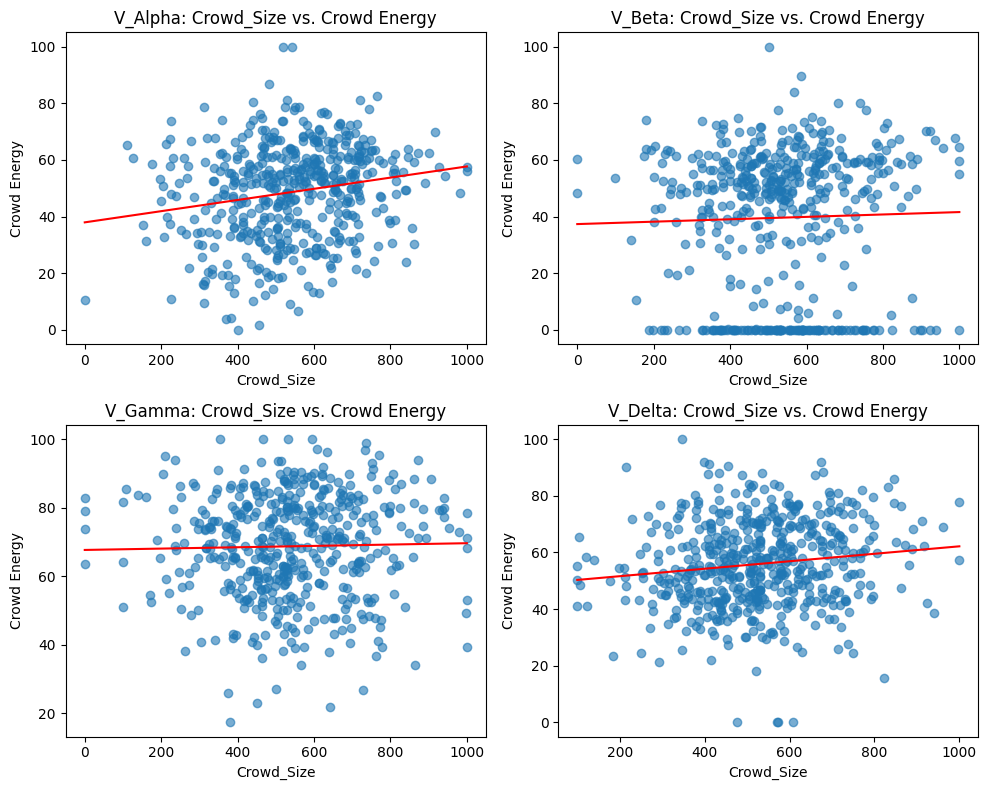

In [425]:
plt.figure(figsize=(10,8))

for i, v in enumerate(venues, 1):
    sub = df[df["Venue_ID"] == v]

    X = sub["Crowd_Size"].to_numpy().reshape(-1, 1)
    y = sub["Crowd_Energy"].to_numpy()
    reg = LinearRegression().fit(X, y)

    x_line = np.linspace(sub["Crowd_Size"].min(), sub["Crowd_Size"].max(), 200)
    y_line = reg.predict(x_line.reshape(-1, 1))


    plt.subplot(2, 2, i)
    plt.scatter(sub["Crowd_Size"], sub["Crowd_Energy"], alpha=0.6, marker="o")
    plt.plot(x_line, y_line, color="red")
    plt.title(f"{v}: Crowd_Size vs. Crowd Energy")
    plt.xlabel("Crowd_Size")
    plt.ylabel("Crowd Energy")

plt.tight_layout()
plt.show()

## Creating the Actual Model

I have decided to go with an AdaBoost Regressor model. This is a type of boosting algorithm that is used to improve the performance of a regression model by combining multiple weak models. The AdaBoost algorithm is an ensemble learning method that combines multiple weak learners to create a strong learner. The AdaBoost algorithm works by training multiple models on different subsets of the training data and then combining their predictions to improve the overall performance of the model.

### Feature Selection

From the above plots, we can choose the features which seem to have the most impact on the energy score. These include:
- Volume level
- Is it a night show?
- Is it a weekend show?
- Ticket Price
- Opener Rating

Then we can split the data into training and testing sets.

In [426]:
categorical_cols = ["Venue_ID"]
numeric_cols = ["Volume_Level", "Ticket_Price", "Opener_Rating", "is_night_show", "is_weekend"]

def keep_necessary_features(df):
    return df[categorical_cols + numeric_cols]

### Creating the pipeline

First we have to convert the Venue_ID into a numerical represenstation. We can use the OneHotEncoder to do so. For the rest of the columns, they can be passed as it is.

**Note:**  We don't have to normalize our features because we are using a decision tree based model, which does not benefit much from normalization.

In [427]:
transform_categorical_cols = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("numeric", "passthrough", numeric_cols)
    ]
)


model = Pipeline(steps=[
    ("tranform", transform_categorical_cols),
    ("adaboost", AdaBoostRegressor(random_state=42))
])

### Testing with default parameters

In [428]:
X = keep_necessary_features(df)
y = df["Crowd_Energy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(scores)
print("Mean R2:", scores.mean())

scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
print(scores)
print("Mean RMSE:", (-scores.mean()) ** 0.5)

[0.46815039 0.41899736 0.38484428 0.44412138 0.38535868]
Mean R2: 0.4202944177832036
[-263.91931891 -261.1941543  -303.12806147 -229.47024349 -258.30683203]
Mean RMSE: 16.223554543926767


### HyperParameter tuning

We can use GridSearchCV to find the best combination of hyperparameters for our model.

In [429]:
param_grid = {
    "adaboost__n_estimators": [200, 500, 1000, 1200, 1500, 2000],
    "adaboost__learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    "adaboost__loss": ["linear", "square", "exponential"],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, # cross validation 5-fold
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

Now we can finally train our brand new model (⁠◕⁠ᴗ⁠◕ ⁠✿⁠)

**This takes around 3 minutes on my laptop.**

In [430]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=200; total time=   0.7s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=200; total time=   0.8s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=200; total time=   0.8s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=200; total time=   0.8s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=200; total time=   0.9s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=500; total time=   1.9s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=500; total time=   1.9s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=500; total time=   1.9s
[CV] END adaboost__learning_rate=0.001, adaboost__loss=linear, adaboost__n_estimators=500; total time=   1.9s
[CV] END a

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'adaboost__learning_rate': [0.001, 0.005, ...], 'adaboost__loss': ['linear', 'square', ...], 'adaboost__n_estimators': [200, 500, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('categorical', ...), ('numeric', ...)]"


And we can output the result of the training and tuning.

In [431]:
print("Best Params:", grid.best_params_)
print("Best R2:", grid.best_score_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

scores = cross_val_score(best_model, X, y, cv=5, scoring="r2")
print(scores)
print("Mean R2:", scores.mean())

scores = cross_val_score(best_model, X, y, cv=5, scoring="neg_mean_squared_error")
print(scores)
print("Mean RMSE:", (-scores.mean()) ** 0.5)

Best Params: {'adaboost__learning_rate': 0.01, 'adaboost__loss': 'exponential', 'adaboost__n_estimators': 500}
Best R2: 0.4766848992054863
[0.48434051 0.43275546 0.45492149 0.46189173 0.41460598]
Mean R2: 0.44970303433512954
[-255.88531197 -255.00909571 -268.59636677 -222.13452779 -246.01547121]
Mean RMSE: 15.796460194910976


## Using the model to predict the test dataset

We can load the test dataset, preprocess it and then use the best_model to generate outputs.

In [432]:
test_df = pd.read_csv("tour_logs_test_input.csv")
test_df = preprocess(test_df)
X = keep_necessary_features(test_df)

Y = best_model.predict(X)

output = pd.DataFrame({"Gig_ID": test_df["Gig_ID"], "Crowd_Energy": Y})
print(output)

output.to_csv("predictions.csv", index=False)

       Gig_ID  Crowd_Energy
0    Gig_0000     55.938728
1    Gig_0001     41.258248
2    Gig_0002     56.244522
3    Gig_0003     24.328421
4    Gig_0004     55.712038
..        ...           ...
495  Gig_0495     24.746647
496  Gig_0496     56.779218
497  Gig_0497     55.368975
498  Gig_0498     56.274007
499  Gig_0499     56.231932

[500 rows x 2 columns]


## Bonus Objective: Revenue Optimization

We can visualize the merch sales vs different statistics for V_Gamma.

6       1372
8        583
11       642
12       946
13       540
        ... 
1966    1076
1968     809
1970     899
1977     811
1991     833
Name: Merch_Sales_Post_Show, Length: 485, dtype: int64


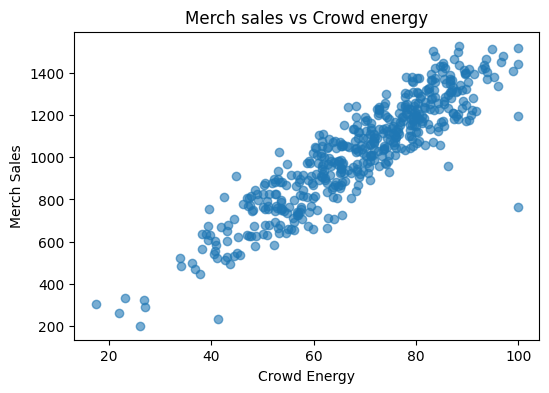

In [433]:
gamma = df[df["Venue_ID"] == "V_Gamma"]
print(gamma["Merch_Sales_Post_Show"])

plt.figure(figsize=(6,4))
plt.scatter(gamma["Crowd_Energy"], gamma["Merch_Sales_Post_Show"], alpha=0.6, marker="o")
plt.title("Merch sales vs Crowd energy")
plt.xlabel("Crowd Energy")
plt.ylabel("Merch Sales")
plt.show()

Clearly, there is a linear relationship between energy and the amount of merch bought. We can fit a linear regression model to this data.

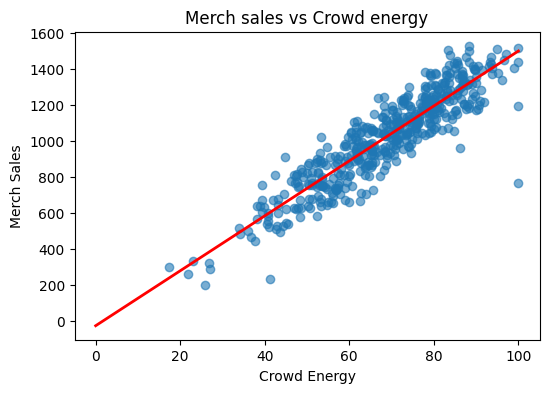

In [434]:
X = gamma["Crowd_Energy"].to_numpy().reshape(-1, 1)
y = gamma["Merch_Sales_Post_Show"].to_numpy()
sales_vs_energy_reg = LinearRegression().fit(X, y)

x_line = np.linspace(sub["Crowd_Energy"].min(), sub["Crowd_Energy"].max(), 200)
y_line = sales_vs_energy_reg.predict(x_line.reshape(-1, 1))

plt.figure(figsize=(6,4))
plt.scatter(gamma["Crowd_Energy"], gamma["Merch_Sales_Post_Show"], alpha=0.6, marker="o")
plt.plot(x_line, y_line, color="red", linewidth=2)
plt.title("Merch sales vs Crowd energy")
plt.xlabel("Crowd Energy")
plt.ylabel("Merch Sales")
plt.show()

> Attendance may be affected by both ticket price and crowd energy—but Rick doesn't know exactly how

We can try to find a model that predicts crowd size based on ticket price and energy. The following are two plots of crowd size vs energy and crowd size vs ticket price.

I cannot see any clear correlation between the two variables.

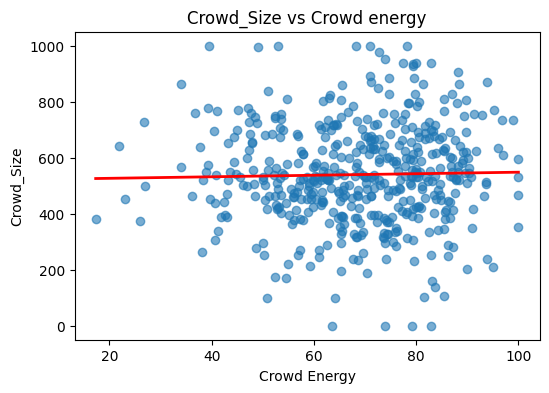

In [435]:
X = gamma["Crowd_Energy"].to_numpy().reshape(-1, 1)
y = gamma["Crowd_Size"].to_numpy()
reg = LinearRegression().fit(X, y)

x_line = np.linspace(gamma["Crowd_Energy"].min(), gamma["Crowd_Energy"].max(), 200)
y_line = reg.predict(x_line.reshape(-1, 1))

plt.figure(figsize=(6,4))
plt.scatter(gamma["Crowd_Energy"], gamma["Crowd_Size"], alpha=0.6, marker="o")
plt.plot(x_line, y_line, color="red", linewidth=2)
plt.title("Crowd_Size vs Crowd energy")
plt.xlabel("Crowd Energy")
plt.ylabel("Crowd_Size")
plt.show()

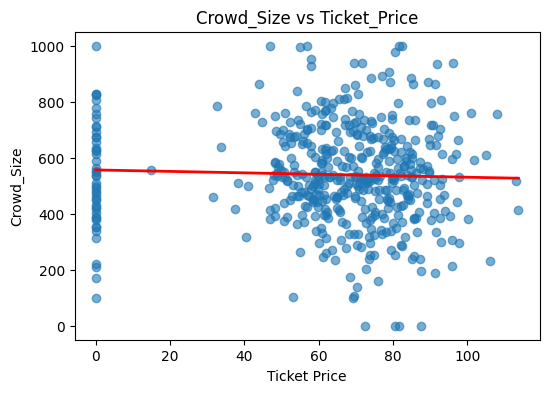

In [436]:
X = gamma["Ticket_Price"].to_numpy().reshape(-1, 1)
y = gamma["Crowd_Size"].to_numpy()
reg = LinearRegression().fit(X, y)

x_line = np.linspace(gamma["Ticket_Price"].min(), gamma["Ticket_Price"].max(), 200)
y_line = reg.predict(x_line.reshape(-1, 1))

plt.figure(figsize=(6,4))
plt.scatter(gamma["Ticket_Price"], gamma["Crowd_Size"], alpha=0.6, marker="o")
plt.plot(x_line, y_line, color="red", linewidth=2)
plt.title("Crowd_Size vs Ticket_Price")
plt.xlabel("Ticket Price")
plt.ylabel("Crowd_Size")
plt.show()

We can train a similar regression model to predict crowd_size based on different features. 

Although, the model fails to pick up on any trends in the data.
Still, we can move on with it.

In [437]:
size_model = AdaBoostRegressor(learning_rate=0.002, random_state=42)

numeric_cols = ["Ticket_Price", "is_night_show", "is_weekend", "Crowd_Energy"]
categorical_cols = []

X = keep_necessary_features(gamma)
y = gamma["Crowd_Size"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

size_model.fit(X_train, Y_train)

y_pred = size_model.predict(X_test)

scores = cross_val_score(size_model, X, y, cv=5, scoring="r2")
print(scores)
print("Mean R2:", scores.mean())

scores = cross_val_score(size_model, X, y, cv=5, scoring="neg_mean_squared_error")
print(scores)
print("Mean RMSE:", (-scores.mean()) ** 0.5)


[0.0507162  0.09155005 0.12624316 0.11956587 0.01382953]
Mean R2: 0.08038096063556774
[-40129.78889816 -22506.43203846 -27909.1345138  -24954.98374941
 -29314.69777812]
Mean RMSE: 170.1852149735355


### The actual optimization code

We loop over all price points from $1 to $120. For each price point, and a given set of assumptions, we calculate the predicted Crowd_Energy. This, combined with other features can be used to predict the Crowd Size.

Then, we use the following Revenue formula:

```
Net Revenue = $30 × Predicted Merch Sales – $8 × Predicted Crowd Size - $5000
```

Where we have assumed a merch costs $30 on average.

We can then plot the revenue against the price point, and see how the price affects the revenue.

[18328.93398992]
[18328.93398992]
[18328.93398992]
[18328.93398992]
[18328.93398992]
[18328.93398992]
[18328.93398992]
[16951.40294241]
[16951.40294241]
[16951.40294241]
[16951.40294241]
[16951.40294241]
[16951.40294241]
[16951.40294241]
[16951.40294241]
[16921.47634262]
[16865.14765338]
[16865.14765338]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16843.43401617]
[16710.34714133]
[16710.34714133]
[16611.00711348]
[16591.21938606]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16556.27483256]
[16563.28357507]
[16563.28357507]
[16563.28357507]
[16563.28357507]
[16603.84337398]
[16731.37248929]
[16918.8310648

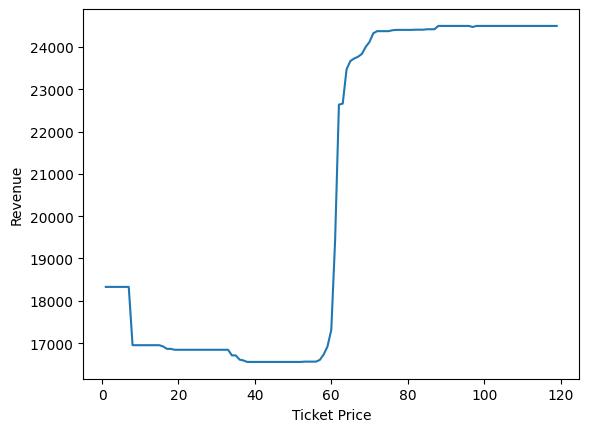

In [438]:
prices = []
revenues = []

for price in range(1, 120, 1):
    sample = pd.DataFrame([{
        "Venue_ID": "V_Gamma",
        "Volume_Level": 10,
        "Ticket_Price": price,
        "Opener_Rating": 4,
        "is_night_show": True,
        "is_weekend": False,
    }])
    energy = best_model.predict(sample)

    sample = pd.DataFrame([{
        "Ticket_Price": price,
        "is_night_show": True,
        "is_weekend": False,
        "Crowd_Energy": energy,
    }])
    crowd_size = size_model.predict(sample)[0]
    revenue = 30 * sales_vs_energy_reg.predict(energy[0].reshape(-1, 1)) - 8 * crowd_size - 5000
    
    print(revenue)

    prices.append(price)
    revenues.append(revenue)

plt.plot(prices, revenues)
plt.xlabel("Ticket Price")
plt.ylabel("Revenue")
plt.show()  

From the above plot, the maximum revenue occurs around a Ticket price of **$90**, and the curve flattens outu after that. This is the optimal price for the venue V_Gamma.